In [92]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [93]:
import pandas as pd

Raw = pd.read_csv("./DXY.csv")
Raw.head()

,Actual,LS/ZB/1/wo,RI/ZB/1/wo,LA/ZB/1/wo
0,-0.003483,0.020729,0.013981,0.014704
1,-0.021061,0.019817,0.000327,0.001228
2,-0.024398,0.013153,-0.014779,-0.015592
3,-0.020540,0.000261,-0.019604,-0.021380
4,-0.024582,-0.013340,-0.014982,-0.012665


In [107]:
Data = pd.DataFrame()

In [108]:
Data["Result"] = (Raw["Actual"]>0).astype(int)
Data.head()


,Result
0,0
1,0
2,0
3,0
4,0


In [113]:
Data = Data.dropna()
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1475 entries, 0 to 1474
Data columns (total 4 columns):
Result    1475 non-null int64
LSTM      1475 non-null float64
Ridge     1475 non-null float64
LASSO     1475 non-null float64
dtypes: float64(3), int64(1)
memory usage: 57.6 KB


In [111]:
Data["LSTM"] = Raw["LS/ZB/1/wo"]
Data["Ridge"] = Raw["RI/ZB/1/wo"]
Data["LASSO"] = Raw["LA/ZB/1/wo"]
Data.head()

,Result,LSTM,Ridge,LASSO
0,0,0.020729,0.013981,0.014704
1,0,0.019817,0.000327,0.001228
2,0,0.013153,-0.014779,-0.015592
3,0,0.000261,-0.019604,-0.021380
4,0,-0.013340,-0.014982,-0.012665


In [119]:
X = Data.drop(["Result"],axis=1).values
y = Data["Result"].values
len(X)

1475

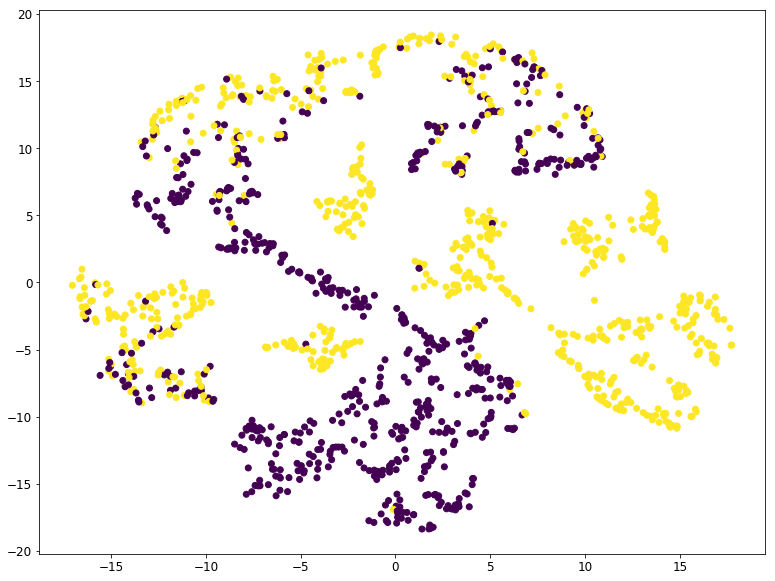

In [120]:
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
X_reduced = pca_tsne.fit_transform(X)

plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
#plt.axis("off")
plt.show()

## Deep Learning

In [122]:
import tensorflow as tf
from sklearn import cross_validation

In [123]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

In [124]:
print(len(X_train), len(X_test)/len(X_train), len(X))

1180 0.25 1475


In [125]:
n_inputs = 3
n_hidden1 = 10
n_hidden2 = 10
n_output = 2

In [126]:
X = tf.placeholder(tf.float32,shape=(None, n_inputs), name = "X")
y = tf.placeholder(tf.int64,shape=(None), name = "y")

In [127]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b        

        batch_mean,batch_var = tf.nn.moments(Z,[0])
        scale = tf.Variable(tf.ones([n_neurons]))
        beta  = tf.Variable(tf.zeros([n_neurons]))
        Z_batch = tf.nn.batch_normalization(Z,batch_mean,batch_var,beta,scale,1e-3)
        
        if activation is not None:
            return activation(Z_batch)
        else:
            return Z_batch

In [128]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.sigmoid)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.sigmoid)
    logits = neuron_layer(hidden2, n_output, name="outputs")

In [129]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [130]:
learning_rate = 0.03

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [131]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [132]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 100
batch_size = 50

In [133]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        sess.run(training_op, feed_dict={X: X_train, y: y_train})
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        acc_test = accuracy.eval(feed_dict={X: X_test,
                                            y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.688983 Test accuracy: 0.688136
1 Train accuracy: 0.736441 Test accuracy: 0.728814
2 Train accuracy: 0.800847 Test accuracy: 0.816949
3 Train accuracy: 0.845763 Test accuracy: 0.861017
4 Train accuracy: 0.883051 Test accuracy: 0.884746
5 Train accuracy: 0.887288 Test accuracy: 0.915254
6 Train accuracy: 0.89322 Test accuracy: 0.915254
7 Train accuracy: 0.889831 Test accuracy: 0.915254
8 Train accuracy: 0.889831 Test accuracy: 0.911864
9 Train accuracy: 0.884746 Test accuracy: 0.901695
10 Train accuracy: 0.882203 Test accuracy: 0.901695
11 Train accuracy: 0.881356 Test accuracy: 0.911864
12 Train accuracy: 0.878814 Test accuracy: 0.908475
13 Train accuracy: 0.878814 Test accuracy: 0.915254
14 Train accuracy: 0.882203 Test accuracy: 0.915254
15 Train accuracy: 0.883051 Test accuracy: 0.915254
16 Train accuracy: 0.888983 Test accuracy: 0.908475
17 Train accuracy: 0.89322 Test accuracy: 0.908475
18 Train accuracy: 0.894068 Test accuracy: 0.905085
19 Train accuracy: 0.898